In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
region_df = pd.read_pickle('../data/regiondatav0.pk')
rev_df = pd.read_pickle('../data/reviewsred.pk')

There may be recipes that appear in one dataset but not the other; we will get rid of any recipes that don't appear in both.

In [8]:
recipe_ids = list(set(region_df.index).intersection(set(rev_df.RecipeId.values)))
region_df = region_df[region_df.index.isin(recipe_ids)]
rev_df = rev_df[rev_df['RecipeId'].isin(recipe_ids)].copy()

In [9]:
rev_df['Continents'] = [region_df['Continents'][r] for r in rev_df.RecipeId]
rev_df['Regions'] = [region_df['Regions'][r] for r in rev_df.RecipeId]

Now, we're going to do a train-test split stratified by user. If there are users with only one review, we won't be able to do a stratified split, so we should drop those users. We will in fact drop users who have less than 20 reviews to ensure we only look at people with enough data.

In [46]:
usercounts = rev_df.UserId.value_counts()
revs = (rev_df.groupby('UserId').filter(lambda x: len(x) > 19))
revs = (revs.groupby('RecipeId').filter(lambda x: len(x) > 9))
revs = (revs.groupby('UserId').filter(lambda x: len(x) > 9)).copy()



In [52]:
regs_masterlist = []
for l in region_df.Regions:
    regs_masterlist+=list(l)

for l in region_df.Continents:
    regs_masterlist+=list(l)

regs_masterlist = list(set(regs_masterlist))

regkw_to_ind = {regs_masterlist[i]:i for i in range(len(regs_masterlist))}

def to_reg_vec(regkws):
    vec = np.zeros(len(regs_masterlist))
    for w in regkws:
        vec[regkw_to_ind[w]]+=1
    return vec

In [48]:
from sklearn.model_selection import train_test_split

revs_train, revs_test = train_test_split(revs,test_size=0.2,random_state=193,stratify=revs.UserId)

In [49]:
revs_train

,UserId,RecipeId,Rating,Continents,Regions
ReviewId,,,,,
1165351,780172,360542,5,[european],"[italian, greek]"
1212362,46357,33170,4,"[oceania/islands, european]","[caribbean, italian]"
786707,591302,154267,5,[european],[french]
991068,209318,211484,5,[european],[french]
1453316,1175362,30505,0,[european],[]
...,...,...,...,...,...
50999,21752,53345,5,[european],[italian]
445387,167242,13285,5,[european],[greek]
1128894,47892,427556,4,"[asian, european]",[italian]


In [91]:
def getdics(df,usercol,itemcol):
    user_to_recs = {user:[] for user in set(df[usercol].values)}
    rec_to_users= {rec:[] for rec in set(df[itemcol].values)}
    for rev in df.index:
        user = df[usercol][rev]
        rec = df[itemcol][rev]
        user_to_recs[user].append(rec)
        rec_to_users[rec].append(user)
    return user_to_recs,rec_to_users

user_to_recs_train,rec_to_users_train = getdics(revs_train,'UserId','RecipeId')


In [92]:
user_to_recs_test,rec_to_users_test = getdics(revs_test,'UserId','RecipeId')


In [70]:
rec_vecs = {recipe:to_reg_vec(region_df['Regions'][recipe]) for recipe in region_df.index}
for recipe in rec_vecs:
    rec_vecs[recipe]+=to_reg_vec(region_df['Continents'][recipe])
user_vecs_train = {}
for user in user_to_recs_train:
    user_vecs = [rec_vecs[rec] for rec in user_to_recs_train[user]]
    user_vecs_train[user] = sum(user_vecs)/len(user_vecs)


In [71]:
rec_mean = sum(list(rec_vecs.values()))/len(rec_vecs)
user_mean  = sum(list(user_vecs_train.values()))/len(user_vecs_train)

In [72]:
user_vecs_train_norm = {}
rec_vecs_norm = {}
for user in user_vecs_train:
    vtransl = user_vecs_train[user]-rec_mean
    user_vecs_train_norm[user] = vtransl/np.linalg.norm(vtransl)

for rec in rec_vecs:
    vtransl = rec_vecs[rec]-rec_mean
    rec_vecs_norm[rec] = vtransl/np.linalg.norm(vtransl)

In [66]:
recipes_in_trainingset = list(revs_train.RecipeId.unique())

In [74]:
user_distance_dicts = {}
user_dot_dicts = {}
for user in revs_train.UserId.unique():
    user_dist= {}
    user_dot = {}
    for recipe in recipes_in_trainingset:
        user_dist[recipe] = np.linalg.norm(user_vecs_train[user]-rec_vecs[recipe])
        user_dot[recipe] = np.dot(user_vecs_train_norm[user],rec_vecs_norm[recipe])
    user_distance_dicts[user] = user_dist
    user_dot_dicts[user] = user_dot

In [77]:
revs_train.UserId.value_counts()

UserId
140132    646
37449     446
126440    433
383346    372
128473    329
         ... 
105459      8
163872      8
316233      8
756031      8
1533        8
Name: count, Length: 2538, dtype: int64

In [78]:
user_list = list(revs_train.UserId.unique())

In [86]:
def complement_userrecs_training(reclist):
    return list(set(recipes_in_trainingset)-set(reclist))

In [80]:
user_list.sort(key = lambda x : len(user_to_recs_train[x]),reverse=True)

In [84]:
def means_user_subset(user:int,reclist:list)->dict:
    mean_dist = np.mean([user_distance_dicts[user][rec] for rec in reclist])
    mean_dot = np.mean([user_dot_dicts[user][rec] for rec in reclist])
    return {'mean_dist':mean_dist,'mean_dot':mean_dot}

In [85]:
means_user_subset(user_list[0],user_to_recs_train[user_list[0]])

{'mean_dist': 1.2667314739711197, 'mean_dot': 0.06486592582224683}

In [87]:
means_user_subset(user_list[0],complement_userrecs_training(user_to_recs_train[user_list[0]]))

{'mean_dist': 1.26059736739536, 'mean_dot': -0.014363279373810166}

In [93]:
means_user_subset(user_list[0],user_to_recs_test[user_list[0]])

{'mean_dist': 1.293836999241262, 'mean_dot': 0.06265610362038936}

In [136]:
user_dots_test = {user:means_user_subset(user,user_to_recs_test[user])['mean_dot'] for user in user_list}

In [137]:
user_dots_comp =  {user:means_user_subset(user,complement_userrecs_training(user_to_recs_train[user]+user_to_recs_test[user]))['mean_dot'] 
                   for user in user_list}

In [138]:
np.mean(list(user_dots_test.values()))

0.10110471275415188

In [139]:
np.mean(list(user_dots_comp.values()))

0.00045694157476206486

In [144]:
def user_dot_groups(user):
    user_train = [user_dot_dicts[user][rec] for rec in recipes_in_trainingset if rec in user_to_recs_train[user]]
    user_test = [user_dot_dicts[user][rec] for rec in recipes_in_trainingset if rec in user_to_recs_test[user]]
    user_other_recs = [user_dot_dicts[user][rec] for rec in recipes_in_trainingset if rec not in set(user_to_recs_train[user]+user_to_recs_test[user])]
    return {'train':user_train,'test':user_test,'other':user_other_recs}

In [97]:
rec_train_counts=revs_train['RecipeId'].value_counts()

In [143]:
def user_pop_groups(user):
    user_train = [rec_train_counts[rec] for rec in recipes_in_trainingset if rec in user_to_recs_train[user]]
    user_test = [rec_train_counts[rec] for rec in recipes_in_trainingset if rec in user_to_recs_test[user]]
    user_other_recs = [rec_train_counts[rec] for rec in recipes_in_trainingset if rec not in set(user_to_recs_train[user]+user_to_recs_test[user])]
    return {'train':user_train,'test':user_test,'other':user_other_recs}

In [104]:
def user_plot_data(user,sizes,colors):
    user_dot_data = user_dot_groups(user)
    user_pop_data = user_pop_groups(user)
    ntrain = len(user_dot_data['train'])
    ntest= len(user_dot_data['test'])
    nother = len(user_dot_data['other'])
    return {'dot':user_dot_data['train']+user_dot_data['test']+user_dot_data['other'],
                 'pop':user_pop_data['train']+user_pop_data['test']+user_pop_data['other'],
                 'sizes':ntrain*[sizes[0]]+ntest*[sizes[1]]+nother*[sizes[2]],
                 'colors':ntrain*[colors[0]]+ntest*[colors[1]]+nother*[colors[2]]}

In [140]:
def make_user_scatterpl(user,sizes,colors):
    user_dot_data = user_dot_groups(user)
    user_pop_data = user_pop_groups(user)
    ntrain = len(user_dot_data['train'])
    ntest= len(user_dot_data['test'])
    nother = len(user_dot_data['other'])
    plt.scatter(x = user_dot_data['train']+user_dot_data['test']+user_dot_data['other'],
                y = user_pop_data['train']+user_pop_data['test']+user_pop_data['other'],
                s = ntrain*[sizes[0]]+ntest*[sizes[1]]+nother*[sizes[2]],
                c = ntrain*[colors[0]]+ntest*[colors[1]]+nother*[colors[2]])
    plt.show()

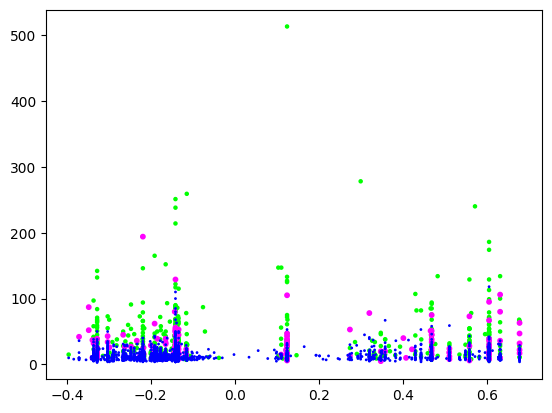

In [151]:
make_user_scatterpl(user_list[0],[5,10,1],[[0,1,0],[1,0,1],[0,0,1]])

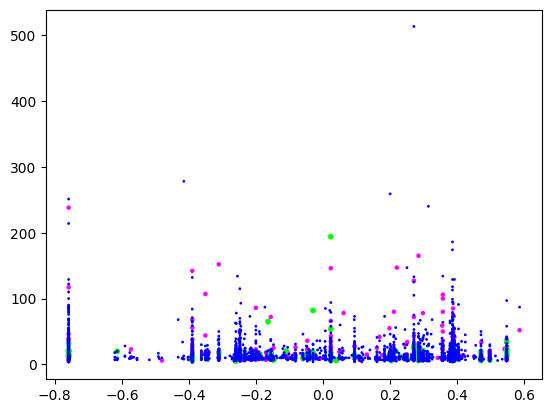

In [152]:
make_user_scatterpl(user_list[1],[5,10,1],[[1,0,1],[0,1,0],[0,0,1]])

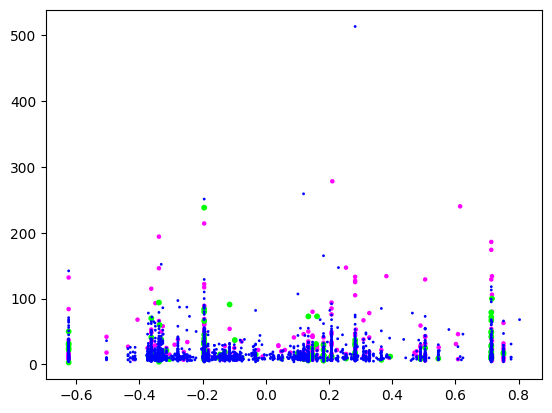

In [153]:
make_user_scatterpl(user_list[2],[5,10,1],[[1,0,1],[0,1,0],[0,0,1]])

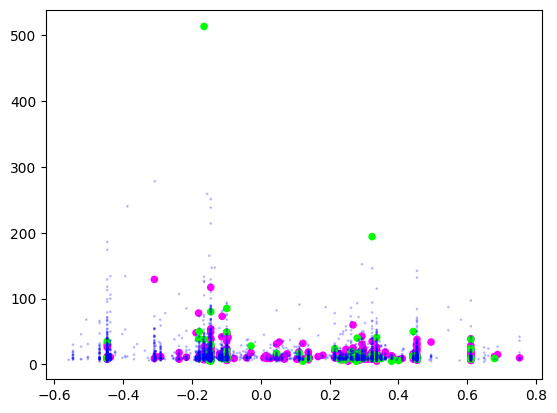

In [158]:
make_user_scatterpl(user_list[4],[10,20,1],[[1,0,1],[0,1,0],[0,0,1,0.2]])

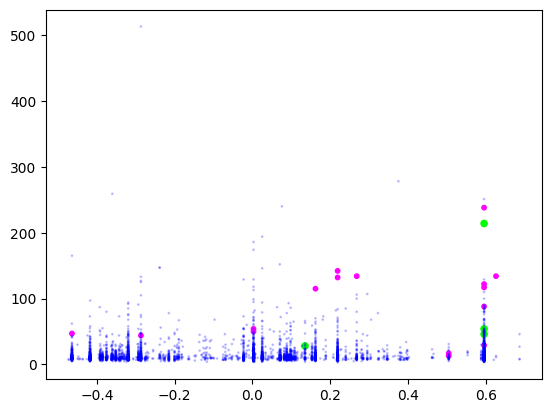

In [164]:
make_user_scatterpl(user_list[-1000],[10,20,1],[[1,0,1],[0,1,0],[0,0,1,0.2]])